📊 Loading cleaned IoT data from Week 6...
📄 First few rows of cleaned data:
             timestamp device_id    data_type  data_value  numeric_value
0  2025-06-06 18:17:06  PKG85046  temperature        26.0           26.0
1  2025-06-06 18:17:06  PKG85046     humidity        51.6           51.6
2  2025-06-06 18:17:06  PKG85046        shock         0.2            0.2
3  2025-06-06 18:17:07  PKG59811  temperature        11.7           11.7
4  2025-06-06 18:17:07  PKG59811     humidity        84.9           84.9

📊 Data summary:
   📦 Total records: 300
   📱 Unique devices: 100
   📈 Data types: temperature, humidity, shock

🕐 Converting timestamps to datetime format...
✅ Timestamp conversion complete
📅 Date range: 2025-06-06 18:17:06 to 2025-06-06 18:18:59

🚨 Danger Point Analysis:
   ⚠️  TEMPERATURE: 2 danger points (>35)
   ⚠️  HUMIDITY: 6 danger points (>90)
   ⚠️  SHOCK: 5 danger points (>1.0)
   🚨 TOTAL DANGER POINTS: 13

🎨 Setting up visualization environment...

📈 Creating line plot 

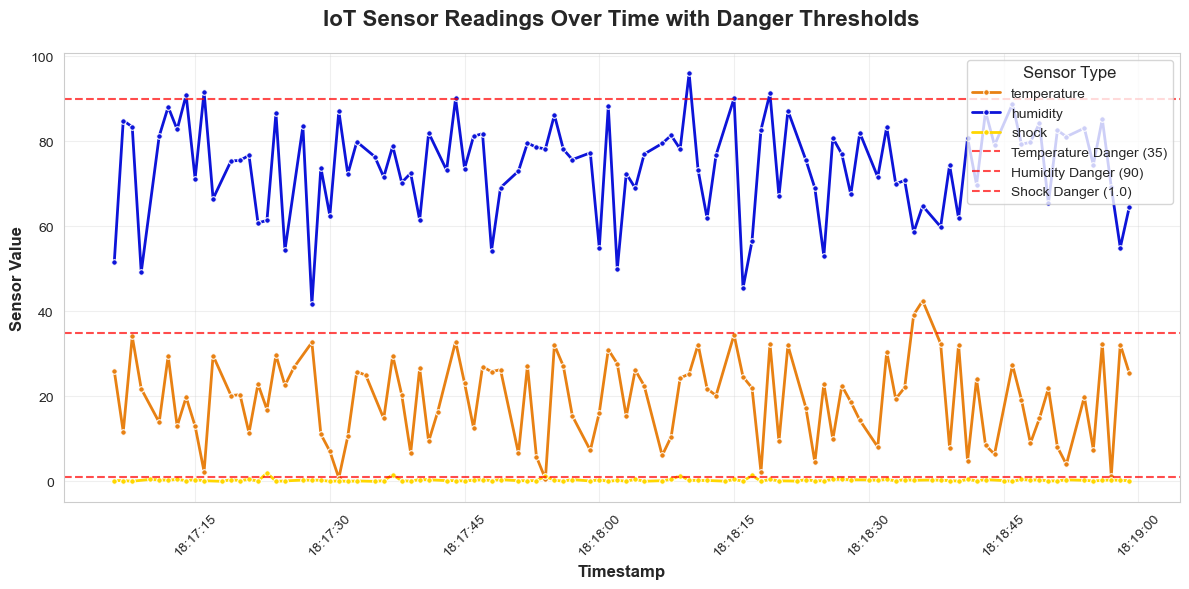


📊 Individual sensor plots with danger thresholds...
✅ Individual sensor plots saved as 'iot_individual_sensors_with_danger.png'


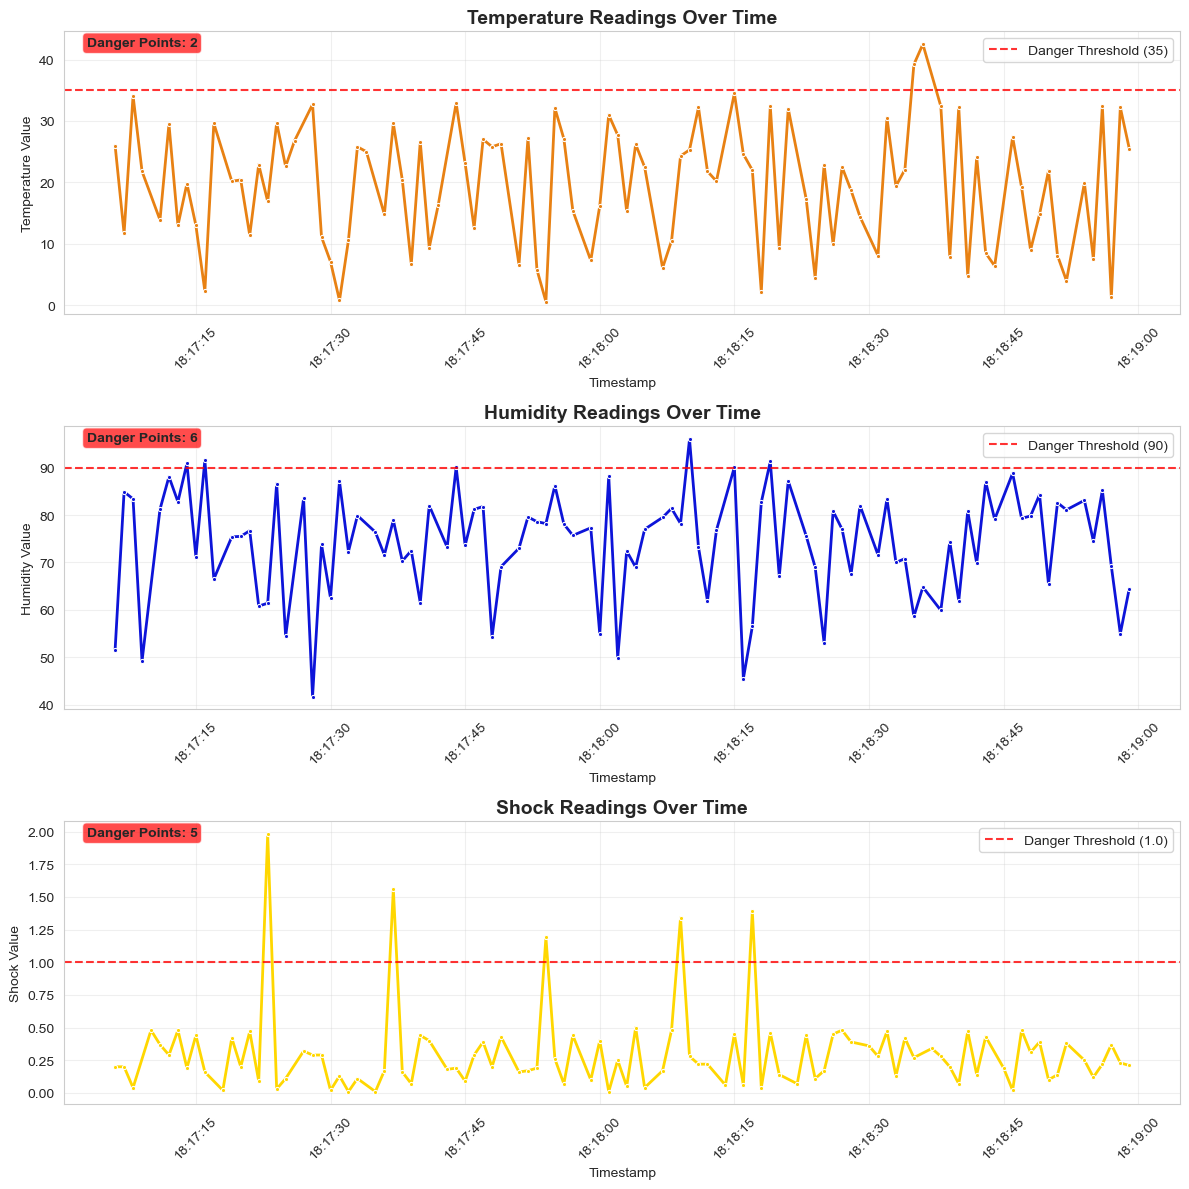


🚨 FINAL DANGER SUMMARY:
   📊 Total readings analyzed: 300
   🚨 Total danger violations: 13
   📈 Safety percentage: 95.7%


In [ ]:
# Week 7: Line Plot of IoT Sensor Readings Over Time with Danger Levels
# This script creates time-series visualizations of IoT sensor data with danger thresholds

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Access your preprocessed data from Week 6
print("📊 Loading cleaned IoT data from Week 6...")

# Load the cleaned IoT data (output from Week 6)
df = pd.read_csv("cleaned_iot_data.csv")

# Display first few rows to verify data structure
print("📄 First few rows of cleaned data:")
print(df.head())

print(f"\n📊 Data summary:")
print(f"   📦 Total records: {len(df)}")
print(f"   📱 Unique devices: {df['device_id'].nunique()}")
print(f"   📈 Data types: {', '.join(df['data_type'].unique())}")

# Step 2: Convert timestamp column to datetime format
print("\n🕐 Converting timestamps to datetime format...")

# Convert timestamp column to pandas datetime format (for proper time-series plotting)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by timestamp to ensure proper chronological order
df = df.sort_values('timestamp')

print("✅ Timestamp conversion complete")
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# NEW: Define danger thresholds for each sensor type
DANGER_THRESHOLDS = {
    'temperature': 35,    # Danger above 35°C
    'humidity': 90,       # Danger above 90%
    'shock': 1.0         # Danger above 1.0g
}

# NEW: Count danger points for each sensor type
print("\n🚨 Danger Point Analysis:")
total_danger_points = 0
for sensor_type in df['data_type'].unique():
    sensor_data = df[df['data_type'] == sensor_type]
    threshold = DANGER_THRESHOLDS.get(sensor_type, float('inf'))
    danger_points = len(sensor_data[sensor_data['numeric_value'] > threshold])
    total_danger_points += danger_points
    
    print(f"   ⚠️  {sensor_type.upper()}: {danger_points} danger points (>{threshold})")

print(f"   🚨 TOTAL DANGER POINTS: {total_danger_points}")

# Step 3: Import required visualization libraries
print("\n🎨 Setting up visualization environment...")

# Set seaborn style for better-looking plots
sns.set_style("whitegrid")

# Set specific colors for each sensor type
sensor_colors = {
    'temperature': "#E88113",  # orange
    'humidity': "#0D14D9",     # royal blue
    'shock': '#FFD700'         # gold/yellow for shock
}

# Set color palette for different sensor types
colors = ['#E88113', '#0D14D9', '#FFD700', '#96CEB4', '#FFEAA7']
sns.set_palette(colors)

# Step 5: Create the line plot with danger threshold lines
print("\n📈 Creating line plot visualization with danger thresholds...")

# Create figure with specified size (width=12, height=6 inches)
plt.figure(figsize=(12, 6))

# Create line plot with seaborn
# x-axis: timestamp (time)
# y-axis: numeric_value (sensor readings)
# hue: data_type (different line for each sensor type)
# marker: adds points on the line for better visibility
sns.lineplot(
    data=df, 
    x="timestamp", 
    y="numeric_value",
    hue="data_type", 
    marker="o", 
    markersize=4,
    linewidth=2
)

# NEW: Add horizontal danger threshold lines
for sensor_type, threshold in DANGER_THRESHOLDS.items():
    if sensor_type in df['data_type'].unique():
        plt.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                   label=f'{sensor_type.title()} Danger ({threshold})')

# Rotate x-axis labels for better readability (45-degree angle)
plt.xticks(rotation=45)

# Add title and axis labels with proper formatting
plt.title("IoT Sensor Readings Over Time with Danger Thresholds", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Sensor Value", fontsize=12, fontweight='bold')

# Customize the legend
plt.legend(title="Sensor Type", title_fontsize=12, fontsize=10, loc='upper right')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Step 7: Display additional plot information with danger analysis
print(f"\n📊 Plot Statistics with Danger Analysis:")
for sensor_type in df['data_type'].unique():
    sensor_data = df[df['data_type'] == sensor_type]
    threshold = DANGER_THRESHOLDS.get(sensor_type, float('inf'))
    danger_count = len(sensor_data[sensor_data['numeric_value'] > threshold])
    
    print(f"   📈 {sensor_type}:")
    print(f"      📊 Records: {len(sensor_data)}")
    print(f"      📏 Range: {sensor_data['numeric_value'].min():.1f} - {sensor_data['numeric_value'].max():.1f}")
    print(f"      📐 Average: {sensor_data['numeric_value'].mean():.1f}")
    print(f"      🚨 Danger Points: {danger_count} (above {threshold})")

# Save the plot as high-quality image
plt.savefig("iot_sensor_timeline_with_danger.png", dpi=300, bbox_inches='tight')
print("✅ Plot saved as 'iot_sensor_timeline_with_danger.png'")

# Step 9: Display the plot
print("\n🖼️ Showing main plot with danger thresholds...")

# Show the plot (this will open a window with the visualization)
plt.show()

# Enhanced: Create individual plots for each sensor type with danger lines
print("\n📊 Individual sensor plots with danger thresholds...")

# Get unique sensor types
sensor_types = df['data_type'].unique()

# Create subplot for each sensor type
fig, axes = plt.subplots(len(sensor_types), 1, figsize=(12, 4*len(sensor_types)))

# Handle case where there's only one sensor type
if len(sensor_types) == 1:
    axes = [axes]

for i, sensor_type in enumerate(sensor_types):
    # Filter data for this sensor type
    sensor_data = df[df['data_type'] == sensor_type]
    
    # Create line plot for this sensor
    sensor_color = sensor_colors.get(sensor_type, colors[i % len(colors)])
    sns.lineplot(
        data=sensor_data, 
        x="timestamp", 
        y="numeric_value",
        ax=axes[i],
        color=sensor_color,
        marker="o",
        markersize=3,
        linewidth=2
    )
    
    # NEW: Add danger threshold line for this specific sensor
    if sensor_type in DANGER_THRESHOLDS:
        threshold = DANGER_THRESHOLDS[sensor_type]
        axes[i].axhline(y=threshold, color='red', linestyle='--', alpha=0.8, 
                       label=f'Danger Threshold ({threshold})')
        
        # Count and display danger points for this sensor
        danger_count = len(sensor_data[sensor_data['numeric_value'] > threshold])
        axes[i].text(0.02, 0.98, f'Danger Points: {danger_count}', 
                    transform=axes[i].transAxes, fontsize=10, fontweight='bold',
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    
    # Customize individual plot
    axes[i].set_title(f"{sensor_type.title()} Readings Over Time", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Timestamp", fontsize=10)
    axes[i].set_ylabel(f"{sensor_type.title()} Value", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# Adjust layout for individual plots
plt.tight_layout()

# Save individual plots
plt.savefig("iot_individual_sensors_with_danger.png", dpi=300, bbox_inches='tight')
print("✅ Individual sensor plots saved as 'iot_individual_sensors_with_danger.png'")

# Show individual plots
plt.show()

# NEW: Final danger summary
print(f"\n🚨 FINAL DANGER SUMMARY:")
print(f"   📊 Total readings analyzed: {len(df)}")
print(f"   🚨 Total danger violations: {total_danger_points}")
print(f"   📈 Safety percentage: {((len(df) - total_danger_points) / len(df) * 100):.1f}%")